In [1]:
import pandas as pd

In [2]:
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Data exploration

In [4]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [7]:
test.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


In [8]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [9]:
train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [10]:
print(train.shape,test.shape)

(913000, 4) (45000, 4)


# Accuracy measure for forecasting

SMAPE , or symmetrical mean absolute percentage error, is one calculation that you can use to check the accuracy of your forecasting methods. Knowing what the SMAPE formula is and the benefits of using it can help you make better financial decisions.

In [11]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Seasonality

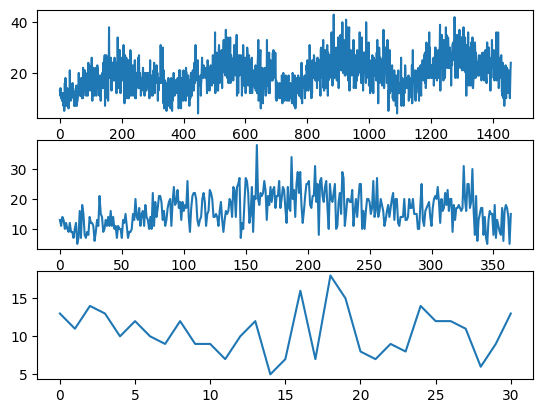

In [14]:
plt.subplot(3, 1, 1)
plt.plot(train.sales[:365*4])
plt.subplot(3, 1, 2)
plt.plot(train.sales[:365])

plt.subplot(3, 1, 3)
plt.plot(train.sales[:31])
plt.show()

In [15]:
rolling_mean = train.sales.rolling(window=7).mean()
print(rolling_mean.shape)
print(rolling_mean[:31])

(913000,)
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6     11.857143
7     11.285714
8     11.428571
9     10.714286
10    10.142857
11     9.714286
12     9.428571
13     9.714286
14     9.142857
15     8.428571
16     9.428571
17     9.142857
18    10.714286
19    11.428571
20    10.857143
21    11.142857
22    11.428571
23    10.285714
24    11.285714
25    10.428571
26    10.000000
27    10.428571
28    10.285714
29    10.285714
30    11.000000
Name: sales, dtype: float64


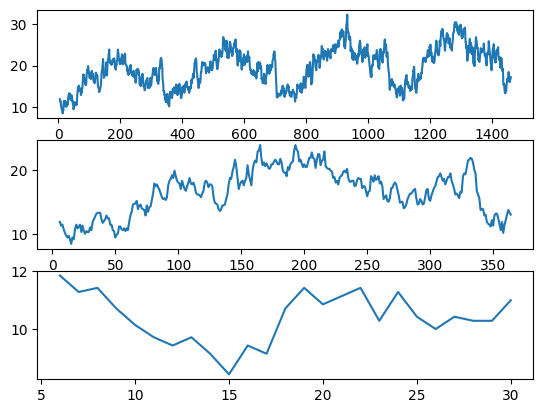

In [16]:
rolling_mean_week = train.sales.rolling(window=7).mean()

plt.subplot(3, 1, 1)
plt.plot(rolling_mean_week[:365*4])

plt.subplot(3, 1, 2)
plt.plot(rolling_mean_week[:365])

plt.subplot(3, 1, 3)
plt.plot(rolling_mean_week[:31])

plt.show()

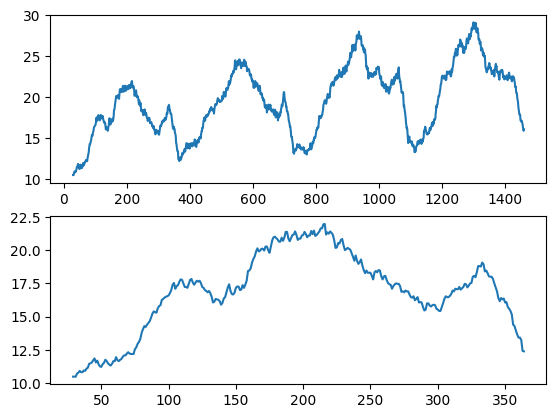

In [17]:
rolling_mean_month = train.sales.rolling(window=30).mean()

plt.subplot(2, 1, 1)
plt.plot(rolling_mean_month[:365*4])

plt.subplot(2, 1, 2)
plt.plot(rolling_mean_month[:365])

plt.show()

# Data pre-processing

In [48]:
data_combine = pd.concat([train,test])
print("size of data_combine",data_combine.shape)

size of data_combine (958000, 5)


In [49]:
data_combine['date'] = pd.to_datetime(data_combine['date'],infer_datetime_format=True)

data_combine['day'] = data_combine['date'].dt.dayofweek
data_combine['month'] = data_combine['date'].dt.month
data_combine['year'] = data_combine['date'].dt.year
data_combine['week_of_year']  = data_combine.date.dt.weekofyear

data_combine['date_order'] = (data_combine['date'] - datetime.datetime(2013, 1, 1)).dt.days

<ipython-input-49-7d8895fd7197>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_combine['week_of_year']  = data_combine.date.dt.weekofyear


In [50]:
data_combine.head(10)

,date,store,item,sales,id,day,month,year,week_of_year,date_order
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,0
1,2013-01-02,1,1,11.0,NaN,2,1,2013,1,1
2,2013-01-03,1,1,14.0,NaN,3,1,2013,1,2
3,2013-01-04,1,1,13.0,NaN,4,1,2013,1,3
4,2013-01-05,1,1,10.0,NaN,5,1,2013,1,4
5,2013-01-06,1,1,12.0,NaN,6,1,2013,1,5
6,2013-01-07,1,1,10.0,NaN,0,1,2013,2,6
7,2013-01-08,1,1,9.0,NaN,1,1,2013,2,7
8,2013-01-09,1,1,12.0,NaN,2,1,2013,2,8
9,2013-01-10,1,1,9.0,NaN,3,1,2013,2,9


In [51]:
data_combine['sale_moving_average_7days']=data_combine.groupby(["item","store"])['sales'].transform(lambda x: x.rolling(window=7,min_periods=1).mean())

In [52]:
data_combine.head(10)

,date,store,item,sales,id,day,month,year,week_of_year,date_order,sale_moving_average_7days
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,0,13.000000
1,2013-01-02,1,1,11.0,NaN,2,1,2013,1,1,12.000000
2,2013-01-03,1,1,14.0,NaN,3,1,2013,1,2,12.666667
3,2013-01-04,1,1,13.0,NaN,4,1,2013,1,3,12.750000
4,2013-01-05,1,1,10.0,NaN,5,1,2013,1,4,12.200000
5,2013-01-06,1,1,12.0,NaN,6,1,2013,1,5,12.166667
6,2013-01-07,1,1,10.0,NaN,0,1,2013,2,6,11.857143
7,2013-01-08,1,1,9.0,NaN,1,1,2013,2,7,11.285714
8,2013-01-09,1,1,12.0,NaN,2,1,2013,2,8,11.428571
9,2013-01-10,1,1,9.0,NaN,3,1,2013,2,9,10.714286


We create 60 day before data using the shift function to introduce new features into the data

In [53]:
data_combine['sale_moving_average_7days_shifted-60']=data_combine.groupby(["item","store"])['sale_moving_average_7days'].transform(lambda x:x.shift(60))
data_combine['sales_shifted-60'] = data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(60))

In [54]:
data_combine[90:100]

,date,store,item,sales,id,day,month,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-60,sales_shifted-60
90,2013-04-01,1,1,11.0,NaN,0,4,2013,14,90,15.285714,11.000000,13.0
91,2013-04-02,1,1,19.0,NaN,1,4,2013,14,91,15.714286,10.571429,11.0
92,2013-04-03,1,1,24.0,NaN,2,4,2013,14,92,17.571429,11.857143,21.0
93,2013-04-04,1,1,18.0,NaN,3,4,2013,14,93,18.285714,12.285714,15.0
94,2013-04-05,1,1,19.0,NaN,4,4,2013,14,94,18.571429,12.714286,14.0
95,2013-04-06,1,1,23.0,NaN,5,4,2013,14,95,19.142857,13.142857,9.0
96,2013-04-07,1,1,17.0,NaN,6,4,2013,14,96,18.714286,13.285714,10.0
97,2013-04-08,1,1,19.0,NaN,0,4,2013,15,97,19.857143,13.285714,13.0
98,2013-04-09,1,1,13.0,NaN,1,4,2013,15,98,19.000000,13.285714,11.0
99,2013-04-10,1,1,19.0,NaN,2,4,2013,15,99,18.285714,12.285714,14.0


We can do other feature engineering, such as including other shifts like:

data_combine['store_item_shifted-10'] = data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(10))

In [55]:
col = [i for i in data_combine.columns if i not in ['date','id','sale_moving_average_7days']]

In [57]:
print("Old train shape: ", train.shape)
train_new = data_combine.loc[~data_combine.sales.isna()]
print("New train shape: ",train_new.shape)
print('---')
print("Old test shape: ", test.shape)
test_new = data_combine.loc[data_combine.sales.isna()]
print("New test shape: ",test_new.shape)

Old train shape:  (913000, 4)
New train shape:  (913000, 13)
---
Old test shape:  (45000, 4)
New test shape:  (45000, 13)


In [58]:
train_new = (train_new[col]).dropna()
print(train_new.shape)

(883000, 10)


# Model building and training

In [59]:
y_target = train_new.sales
col = [i for i in data_combine.columns if i not in ['date','id','sales','sale_moving_average_7days']]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(train_new[col], train_new.sales, test_size=0.15, random_state=42)

In [61]:
model_sets=[]
for max_depth in range(3,17,2):
  xgb_model = xgb.XGBRegressor(max_depth=max_depth ,min_child_weight=1)
  xgb_model.fit(X_train,y_train.values,eval_metric=smape)
  model_sets.append(xgb_model)

  y_train_pred_xgb=xgb_model.predict(X_train)
  y_test_pred_xgb=xgb_model.predict(X_test)
  print('smape error: max_depth=', max_depth ,',train:' , smape(y_train.values,y_train_pred_xgb),'test:',smape(y_test.values,y_test_pred_xgb))
  print('MSE train:' , mean_absolute_error(np.log1p(y_train),np.log1p(y_train_pred_xgb)),'test:',mean_absolute_error(np.log1p(y_test),np.log1p(y_test_pred_xgb)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 3 ,train: 13.57292789581534 test: 13.57461164605118
MSE train: 0.13247179716287735 test: 0.13248696748604222


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 5 ,train: 13.265787230988195 test: 13.292087266175166
MSE train: 0.1294629471415815 test: 0.12972881982955636


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 7 ,train: 12.90825770021601 test: 13.084420026316616
MSE train: 0.12592932121059175 test: 0.12767835037150357


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 9 ,train: 12.34931148554826 test: 12.998039002825882
MSE train: 0.12040399194999009 test: 0.12682631824138454


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 11 ,train: 11.143310229646909 test: 13.080756487440063
MSE train: 0.10851256190518763 test: 0.12763763401746242


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 13 ,train: 8.883104221601494 test: 13.426029776912184
MSE train: 0.0863151310834493 test: 0.1310431793742292


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 15 ,train: 5.557244834321095 test: 13.88351597099027
MSE train: 0.053836467303168725 test: 0.13556889069752315


# Model Testing

Choosing the best model based on the lowest SMAPE results

In [65]:
model_sets[3] # Selecting the best model
y_target = train_new.sales
model_sets[3].fit(train_new[col], y_target, eval_metric=smape) # Fitting the selected model

y_train_pred_xgb = model_sets[3].predict(X_train)
y_test_pred_xgb = model_sets[3].predict(X_test)
print('smape error: ','train:' , smape(y_train.values,y_train_pred_xgb),'test:',smape(y_test.values,y_test_pred_xgb))
print('MSE train:' , mean_absolute_error(np.log1p(y_train),np.log1p(y_train_pred_xgb)),'test:',mean_absolute_error(np.log1p(y_test),np.log1p(y_test_pred_xgb)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error:  train: 12.417496379951245 test: 12.3815985664307
MSE train: 0.12107636240550539 test: 0.12073153525292303


In [66]:
forecast = np.rint(model_sets[3].predict(test_new[col]))

In [68]:
result = pd.DataFrame(list(zip(test_new['id'], forecast)), columns =['id', 'sales'])

In [69]:
result.id = result.id.astype(int)
result.sales = result.sales.astype(int)

In [70]:
# Sample of forecasting
result.head(50)

,id,sales
0,0,15
1,1,17
2,2,16
3,3,17
4,4,17
5,5,19
6,6,20
7,7,14
8,8,17
9,9,16


# LSTM (basis for comparison vs XGBoost)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
tf.random.set_seed(42)

In [14]:
data_combine_lstm = pd.concat([train,test])
print("size of data_combine",data_combine_lstm.shape)

size of data_combine (958000, 5)


In [15]:
data_combine_lstm['date'] = pd.to_datetime(data_combine_lstm['date'],infer_datetime_format=True)

data_combine_lstm['day'] = data_combine_lstm['date'].dt.dayofweek
data_combine_lstm['month'] = data_combine_lstm['date'].dt.month
data_combine_lstm['year'] = data_combine_lstm['date'].dt.year
data_combine_lstm['week_of_year']  = data_combine_lstm.date.dt.weekofyear

data_combine_lstm['date_order'] = (data_combine_lstm['date'] - datetime.datetime(2013, 1, 1)).dt.days

<ipython-input-15-ae13cff1119f>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_combine_lstm['week_of_year']  = data_combine_lstm.date.dt.weekofyear


In [16]:
data_combine_lstm.head(10)

,date,store,item,sales,id,day,month,year,week_of_year,date_order
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,0
1,2013-01-02,1,1,11.0,NaN,2,1,2013,1,1
2,2013-01-03,1,1,14.0,NaN,3,1,2013,1,2
3,2013-01-04,1,1,13.0,NaN,4,1,2013,1,3
4,2013-01-05,1,1,10.0,NaN,5,1,2013,1,4
5,2013-01-06,1,1,12.0,NaN,6,1,2013,1,5
6,2013-01-07,1,1,10.0,NaN,0,1,2013,2,6
7,2013-01-08,1,1,9.0,NaN,1,1,2013,2,7
8,2013-01-09,1,1,12.0,NaN,2,1,2013,2,8
9,2013-01-10,1,1,9.0,NaN,3,1,2013,2,9


In [17]:
col_lstm = [i for i in data_combine_lstm.columns if i not in ['date','id']]

In [18]:
print("Old train shape: ", train.shape)
train_new_lstm = data_combine_lstm.loc[~data_combine_lstm.sales.isna()]
print("New train shape: ",train_new_lstm.shape)
print('---')
print("Old test shape: ", test.shape)
test_new_lstm = data_combine_lstm.loc[data_combine_lstm.sales.isna()]
print("New test shape: ",test_new_lstm.shape)

Old train shape:  (913000, 4)
New train shape:  (913000, 10)
---
Old test shape:  (45000, 4)
New test shape:  (45000, 10)


In [20]:
train_new_lstm = (train_new_lstm[col_lstm]).dropna()
print(train_new_lstm.shape) # No NaN values, since we do not use the shift

(913000, 8)


In [21]:
y_target = train_new_lstm.sales
col = [i for i in data_combine_lstm.columns if i not in ['date','id','sales']]
print(col)

['store', 'item', 'day', 'month', 'year', 'week_of_year', 'date_order']


In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=60, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  if i == 0:
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
  else:
    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [24]:
cols_lstm = list(train_new_lstm.columns)
cols_lstm =  cols_lstm[2:3] + cols_lstm[:2] + cols_lstm[3:]
cols_lstm
train_new_lstm = train_new_lstm[cols_lstm]
train_new_lstm.head(3)

,sales,store,item,day,month,year,week_of_year,date_order
0,13.0,1,1,1,1,2013,1,0
1,11.0,1,1,2,1,2013,1,1
2,14.0,1,1,3,1,2013,1,2


In [25]:
values = train_new_lstm.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.056277        0.0        0.0   0.166667        0.0        0.0   
2   0.047619        0.0        0.0   0.333333        0.0        0.0   
3   0.060606        0.0        0.0   0.500000        0.0        0.0   
4   0.056277        0.0        0.0   0.666667        0.0        0.0   
5   0.043290        0.0        0.0   0.833333        0.0        0.0   

   var7(t-1)  var8(t-1)   var1(t)  
1        0.0   0.000000  0.047619  
2        0.0   0.000548  0.060606  
3        0.0   0.001096  0.056277  
4        0.0   0.001644  0.043290  
5        0.0   0.002192  0.051948  


In [26]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.056277,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.047619
2,0.047619,0.0,0.0,0.333333,0.0,0.0,0.0,0.000548,0.060606
3,0.060606,0.0,0.0,0.500000,0.0,0.0,0.0,0.001096,0.056277
4,0.056277,0.0,0.0,0.666667,0.0,0.0,0.0,0.001644,0.043290
5,0.043290,0.0,0.0,0.833333,0.0,0.0,0.0,0.002192,0.051948


In [27]:
# split into train and test sets
values = reframed.values

train_length = int(train_new_lstm.shape[0]*0.85)
train_temp = values[0:train_length, :]
test_temp = values[train_length:, :]

# split into input and outputs
train_X, train_y = train_temp[:, :-1], train_temp[:, -1]
test_X, test_y = test_temp[:, :-1], test_temp[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(776050, 1, 8) (776050,) (136949, 1, 8) (136949,)


Epoch 1/50
10779/10779 [==============================] - 62s 5ms/step - loss: 0.0398 - val_loss: 0.0686
Epoch 2/50
10779/10779 [==============================] - 53s 5ms/step - loss: 0.0390 - val_loss: 0.0648
Epoch 3/50
10779/10779 [==============================] - 52s 5ms/step - loss: 0.0371 - val_loss: 0.0607
Epoch 4/50
10779/10779 [==============================] - 50s 5ms/step - loss: 0.0358 - val_loss: 0.0549
Epoch 5/50
10779/10779 [==============================] - 51s 5ms/step - loss: 0.0356 - val_loss: 0.0524
Epoch 6/50
10779/10779 [==============================] - 50s 5ms/step - loss: 0.0353 - val_loss: 0.0511
Epoch 7/50
10779/10779 [==============================] - 50s 5ms/step - loss: 0.0350 - val_loss: 0.0499
Epoch 8/50
10779/10779 [==============================] - 51s 5ms/step - loss: 0.0347 - val_loss: 0.0490
Epoch 9/50
10779/10779 [==============================] - 51s 5ms/step - loss: 0.0345 - val_loss: 0.0482
Epoch 10/50
10779/10779 [==============================

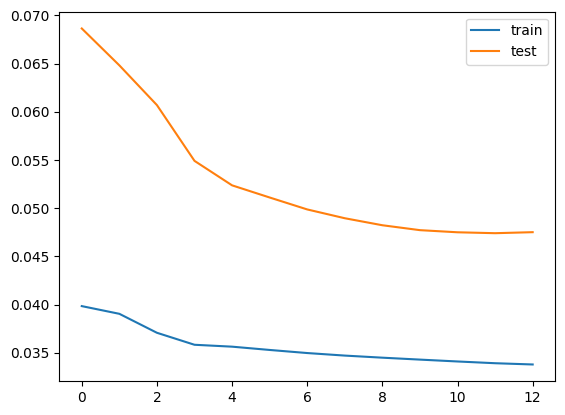

In [29]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=False,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
print(test_X.shape)

(136949, 1, 8)


In [31]:
# make a prediction
yhat = model.predict(test_X)
test_X_new = test_X.reshape((test_X.shape[0], test_X.shape[2]))

4280/4280 [==============================] - 12s 3ms/step


In [41]:
#print(yhat.shape)
#print(inv_yhat.shape)
#print(test_X_new[:, 1:].shape)

(136949, 1)
(136949, 8)
(136949, 7)


In [45]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_new[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
#print(inv_yhat.shape)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_new[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.080


Clearly LSTM does not perform as well as XGBoost